In [126]:
#installation de yfinance et matplotolib pour la récupération des données sur yahoo finance
!pip install yfinance
!pip install matplotlib
import yfinance as yahooFinance
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_X_y
from sklearn import svm
from sklearn.metrics import mean_squared_error
import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


In [166]:
#Importation du cours de l'action de l'entreprise d'assurance AXA

start_Date = datetime.datetime(2019, 1, 1)
end_Date = datetime.datetime(2019, 12, 31)

GetAXAInfo = yahooFinance.Ticker("CS.PA")
df_init=GetAXAInfo.history(start=start_Date,end=end_Date)

In [115]:
len(df_init)

255

In [167]:
df_init.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [168]:
dec=df_init["Close"].shift(1)
df_init= df_init.assign(Close_veille=dec)
df_init.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_veille
Date,,,,,,,,
2019-01-02 00:00:00+01:00,13.595196,13.738302,13.455008,13.731001,8028529,0.0,0,NaN
2019-01-03 00:00:00+01:00,13.599576,13.836142,13.589354,13.617100,6583413,0.0,0,13.731001
2019-01-04 00:00:00+01:00,13.720778,14.087309,13.666748,14.044960,11675578,0.0,0,13.617100
2019-01-07 00:00:00+01:00,14.078546,14.150099,13.900392,13.982167,7530045,0.0,0,14.044960
2019-01-08 00:00:00+01:00,14.027437,14.218734,13.988010,14.034739,7314687,0.0,0,13.982167


In [169]:
#I Donnée
# On remarque que les dates peuvent poser problème => date unix 

df_init = df_init.reset_index()
df_init["Date"] = df_init["Date"].dt.strftime('%Y-%m-%d')
df_init = df_init.set_index('Date')
df_init


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_veille
Date,,,,,,,,
2019-01-02,13.595196,13.738302,13.455008,13.731001,8028529,0.0,0,NaN
2019-01-03,13.599576,13.836142,13.589354,13.617100,6583413,0.0,0,13.731001
2019-01-04,13.720778,14.087309,13.666748,14.044960,11675578,0.0,0,13.617100
2019-01-07,14.078546,14.150099,13.900392,13.982167,7530045,0.0,0,14.044960
2019-01-08,14.027437,14.218734,13.988010,14.034739,7314687,0.0,0,13.982167
...,...,...,...,...,...,...,...,...
2019-12-23,19.585070,19.666321,19.507689,19.646975,3952999,0.0,0,19.658583
2019-12-24,19.546379,19.623760,19.492213,19.546379,1072973,0.0,0,19.646975
2019-12-25,19.546379,19.546379,19.546379,19.546379,0,0.0,0,19.546379


In [176]:
print(max(df_init['Stock Splits']))
print(max(df_init['Dividends']))

#On peut donc supprimer la colonne Stock Splits 
df_init = df_init.drop(columns = ["Stock Splits"])
df_init

0
1.34


,Open,High,Low,Close,Volume,Dividends,Close_veille
Date,,,,,,,
2019-01-02,13.595196,13.738302,13.455008,13.731001,8028529,0.0,NaN
2019-01-03,13.599576,13.836142,13.589354,13.617100,6583413,0.0,13.731001
2019-01-04,13.720778,14.087309,13.666748,14.044960,11675578,0.0,13.617100
2019-01-07,14.078546,14.150099,13.900392,13.982167,7530045,0.0,14.044960
2019-01-08,14.027437,14.218734,13.988010,14.034739,7314687,0.0,13.982167
...,...,...,...,...,...,...,...
2019-12-23,19.585070,19.666321,19.507689,19.646975,3952999,0.0,19.658583
2019-12-24,19.546379,19.623760,19.492213,19.546379,1072973,0.0,19.646975
2019-12-25,19.546379,19.546379,19.546379,19.546379,0,0.0,19.546379


Text(0.5, 0, 'Temps')

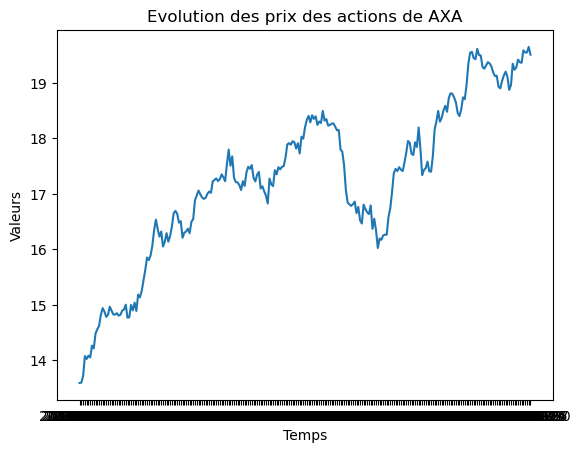

In [177]:
# II Visualisation des données 
#On fait un tableau pour voir l'évolution des prix au cours du temps
df2 = df_init.copy()
new_df = df2[['Open']]
plt.plot(new_df)
plt.title("Evolution des prix des actions de AXA")
plt.ylabel("Valeurs")
plt.xlabel("Temps")


/tmp/ipykernel_203/2883436909.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = df_grouped.sum()


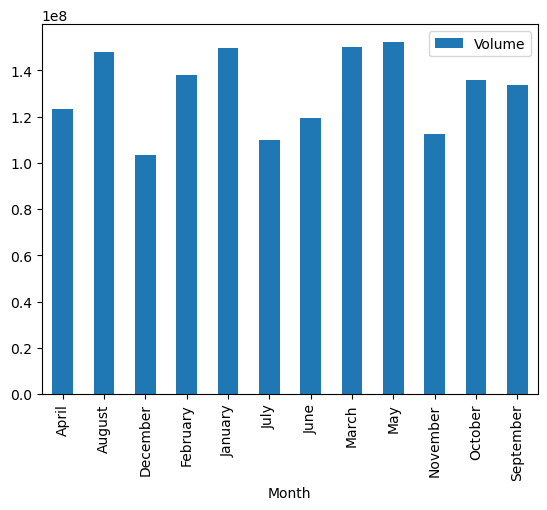

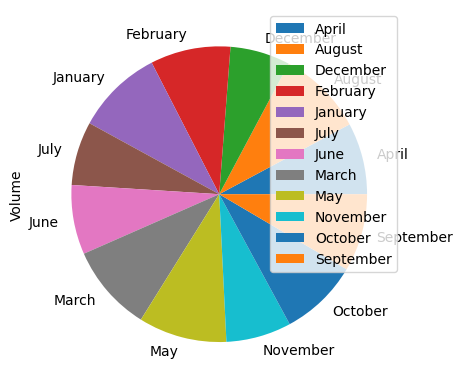

In [178]:
#On veut aussi avoir un histogramme qui nous montre le nombre de transaction par mois de l'action AXA pour voir si il y a
#une évolution 

#On veut aussi avoir un histogramme qui nous montre le nombre de transaction par année de l'action AXA
new_df = df2[['Volume']]
new_df
new_df = new_df.reset_index()
new_df['Month'] = pd.to_datetime(new_df['Date']).dt.strftime('%B')
df_grouped = new_df.groupby(new_df['Month'])


#for key, item in df_grouped:
#    print(key)
#    print(df_grouped.get_group(key))

sums = df_grouped.sum()
sums
sums.plot.bar()
plt.show()

sums.plot.pie(subplots=True)
plt.show()

In [ ]:
# III Modélisation d'un modèle de régression linéaire pour prédire les prix

[[0.85780208 0.12703366]]
Mean squared error: 0.03
Coefficient of determination: 0.97


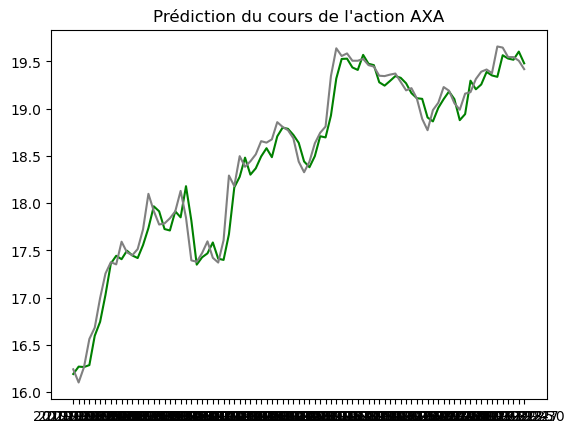

In [179]:
#On fait alors une régression en gardant pour variable explicative les prix de Open et de la fermeture de la veille
X = df2[['Open', 'Close_veille']]
Y = df2[['Close']]
X = X[1:len(X)]
Y = Y[1:len(Y)]



#On définit les tests, pour cela il nous faut une valeur ou arreter les données on la note p
p = int((2/3)*len(X))
X_train = X[:p]
Y_train = Y[:p]
X_test = X[p:]
Y_test = Y[p:]

#On passe désormais à la régression linéaire 
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
print(regr.coef_)

y_pred = regr.predict(X_test)
plt.plot(y_pred, color='green')
plt.plot(Y_test, color='gray')
plt.title("Prédiction du cours de l'action AXA")

from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(Y_test, y_pred))


In [ ]:
#Prédiction avec seulement Open comme variable explicative 

[[0.98557055]]


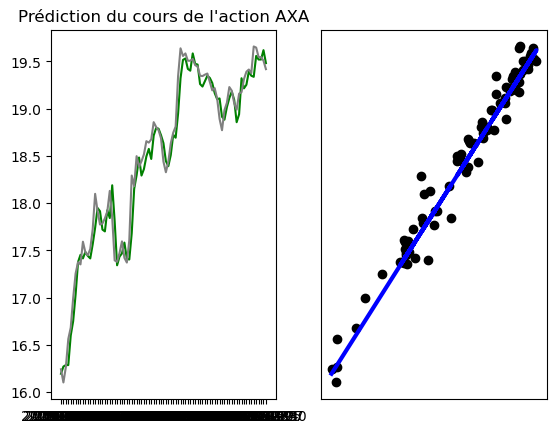

In [180]:
reg = LinearRegression()

X= df2[['Open']]
X = X[1:(len(X))]
p = int((2/3)*len(X))
X_train = X[:p]
X_test = X[p:]
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
print(reg.coef_)

y_pred = reg.predict(X_test)
plt.subplot(121)
plt.plot(y_pred, color='green')
plt.plot(Y_test, color='gray')
plt.title("Prédiction du cours de l'action AXA")

plt.subplot(122)
plt.scatter(X_test, Y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Commenter le graphique 

In [181]:
#Calcul des log-rendements
Log_Rdt=np.log(df_init.Close/df_init.Close_veille)
df_init= df_init.assign(Log_Rdt=Log_Rdt)
df_init.head()

,Open,High,Low,Close,Volume,Dividends,Close_veille,Log_Rdt
Date,,,,,,,,
2019-01-02,13.595196,13.738302,13.455008,13.731001,8028529,0.0,NaN,NaN
2019-01-03,13.599576,13.836142,13.589354,13.617100,6583413,0.0,13.731001,-0.008330
2019-01-04,13.720778,14.087309,13.666748,14.044960,11675578,0.0,13.617100,0.030937
2019-01-07,14.078546,14.150099,13.900392,13.982167,7530045,0.0,14.044960,-0.004481
2019-01-08,14.027437,14.218734,13.988010,14.034739,7314687,0.0,13.982167,0.003753


In [182]:
#Rajout d'un indice temporel dans la base de données
df_init.reset_index(level=None, inplace=True)
df_init= df_init.assign(t=df_init.index)
df_init.head()

,Date,Open,High,Low,Close,Volume,Dividends,Close_veille,Log_Rdt,t
0,2019-01-02,13.595196,13.738302,13.455008,13.731001,8028529,0.0,NaN,NaN,0
1,2019-01-03,13.599576,13.836142,13.589354,13.617100,6583413,0.0,13.731001,-0.008330,1
2,2019-01-04,13.720778,14.087309,13.666748,14.044960,11675578,0.0,13.617100,0.030937,2
3,2019-01-07,14.078546,14.150099,13.900392,13.982167,7530045,0.0,14.044960,-0.004481,3
4,2019-01-08,14.027437,14.218734,13.988010,14.034739,7314687,0.0,13.982167,0.003753,4


In [8]:
#Création d'une base de données d'apprentissage et d'une base de données de test

In [183]:
df=df_init.dropna()
X_BS=pd.DataFrame(df, columns=['Open','Close_veille','t','Log_Rdt'])
y_BS=pd.Series(df.Close)
X_BS_train, X_BS_test, y_BS_train, y_BS_test = train_test_split(X_BS, y_BS, test_size=0.2, random_state=0)

In [184]:
#Calcul de la moyenne des log-rendements
mu=np.mean(X_BS_train.Log_Rdt)
mu

0.0012513736856738

In [185]:
#Estimation de la volatilité des log-rendements : par souci de simplification, nous prenons l'écart-type des log-rendements
sigma=np.std(X_BS_train.Log_Rdt)*np.sqrt(len(X_BS_train))
sigma

0.12558465487181

In [186]:
#Ecriture d'une fonction qui estime le cours de l'action AXA par la formule de Black & Scholes à horizon d jour(s)

def Estim_cours_action(d):
    
    start_Date = datetime.datetime(2019, 1, 1)
    end_Date = datetime.datetime(2019, 12, 31)

    GetAXAInfo = yahooFinance.Ticker("CS.PA")

    df_init=GetAXAInfo.history(start=start_Date,end=end_Date)
    
    #Transformation du cours de l'action de la veille en une variable
    dec=df_init["Close"].shift(1)
    df_init= df_init.assign(Close_veille=dec)
    
    #Calcul des log-rendements
    Log_Rdt=np.log(df_init.Close/df_init.Close_veille)
    df_init= df_init.assign(Log_Rdt=Log_Rdt)
    
    #Rajout d'un indice temporel dans la base de données
    df_init.reset_index(level=0, inplace=True)
    df_init= df_init.assign(t=df_init.index)
    
    #Création d'une base de données d'apprentissage et d'une base de données de test
    df=df_init.dropna()
    X_BS=pd.DataFrame(df, columns=['Open','Close_veille','t','Log_Rdt'])
    y_BS=pd.Series(df.Close)
    X_BS_train, X_BS_test, y_BS_train, y_BS_test = train_test_split(X_BS, y_BS, test_size=0.2, random_state=0)
    
    #Calcul de la moyenne des log-rendements
    mu=np.mean(X_BS_train.Log_Rdt)
    
    #Estimation de la volatilité des log-rendements : par souci de simplification, nous prenons l'écart-type des log-rendements
    sigma=np.std(X_BS_train.Log_Rdt)*np.sqrt(len(X_BS_train))
    
    np.random.seed(94)
    val_norm=np.random.normal(0, 1)

    Est_Close_BS=y_BS_train[min(y_BS_train.index)]*np.exp((mu-(sigma**2)/2)*(d) + sigma*val_norm*np.sqrt(d))
    return Est_Close_BS

In [187]:
#Ecriture d'une fonction qui estime le cours de l'action AXA pour plusieurs horizons temporels donnés

def Estim_cours_action_serie(y):
    indexes=y.index
    Est_Close_BS_serie=[None]*len(indexes)
    j=0
    for i in indexes:
        Est_Close_BS_serie[j]=Estim_cours_action(i)
        j+=1
    Est_Close_BS_serie=pd.Series(Est_Close_BS_serie)
    return Est_Close_BS_serie

In [188]:
Estimation=Estim_cours_action_serie(y_BS_test)
indexes_0=Estimation.index

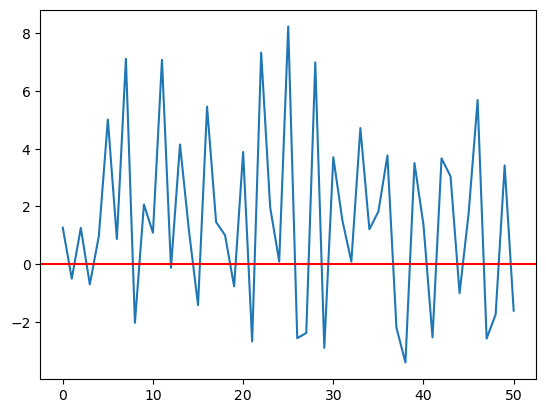

In [189]:
#Représentation graphique dee l'erreur de prédiction entre B&S et série réelle 

y_BS_test.index=indexes_0
Erreur=y_BS_test-Estimation
plt.plot(indexes_0, Erreur)
ay=plt.gca()
ay.axhline(y=0, color='red')

In [190]:
mse_BS=mean_squared_error(Estimation,y_BS_test)
mse_BS

11.569678518126901

In [ ]:
#Mise en oeuvre d'un modèle SVM : on cherche à prédire Close en fonction de Open et de Close_veille

In [191]:
#Base des variables dépendantes et normalisation des données
X_train_init=pd.DataFrame(X_BS_train, columns=['Open','Close_veille'])
X_test_init=pd.DataFrame(X_BS_test, columns=['Open','Close_veille'])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_init)
X_test = scaler.fit_transform(X_test_init)
column_names_train = X_train_init.columns
column_names_test = X_test_init.columns
X_train=pd.DataFrame(X_train, columns=column_names_train)
X_test=pd.DataFrame(X_test, columns=column_names_test)

In [192]:
#Vecteur de variable dépendante
y_train=y_BS_train
y_test=y_BS_test

In [193]:
#Mise en oeuvre du modèle
m1=svm.SVR()
m1.fit(X_train, y_train)

SVR()

In [23]:
#Evaluation du modèle SVM : calcul de : accuracy
accuracy = m1.score(X_test, y_test)
accuracy

0.953806196610228

In [24]:
#Evaluation du modèle SVM : calcul du MSE
y_pred=m1.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
mse

0.0681112844461976

In [ ]:
#En comparant les deux modèles (sur la base du critère MSE), il ressort que le modèle SVM (pour régression) est plus performant que la formule de B&S pour estimer le cours de l'action AXA à la clôture.
#Le modèle SVM a en effet produit un MSE beaucoup plus faible.

#On note également la bonne qualité de l'ajustement par modèle SVM, avec un accuracy à plus de 95%.

In [82]:
np.random.seed(111111000)
val_n=np.random.normal(0, 1)
val_n

0.29929814397553406